In [8]:
import os
import re
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
import shap
import matplotlib.pyplot as plt
from tensorflow.keras.layers import MultiHeadAttention, Dense, Dropout, LayerNormalization, Input, GlobalAveragePooling1D

In [9]:
# 1. Metadata Ön İşleme
metadata_path = 'cleaned_movies4.csv'
metadata_df = pd.read_csv(metadata_path)

# Poster isimlerini normalize etme
def clean_filename(title):
    title = re.sub(r'[^\w\s\-\'\.\!\&\(\)]', '', title)  # Özel karakterleri kaldır (- ve ' hariç)
    return title

metadata_df['Poster_Filename'] = metadata_df['Title'].apply(clean_filename) + '_' + metadata_df['Year'].astype(str) + '.jpg'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# 2. Poster İşleme
poster_folder = '/content/drive/MyDrive/posters'
image_size = (224, 224)

x=0
y=0
# Görüntüleri işleme ve normalize etme
X_images = []
for filename in metadata_df['Poster_Filename']:
    img_path = os.path.join(poster_folder, filename)
    if os.path.exists(img_path):
        img = Image.open(img_path).convert('RGB')
        img = img.resize(image_size)
        img = np.array(img) / 255.0
        X_images.append(img)
        x +=1
    else:
        print(filename)
        y+=1
        X_images.append(np.zeros((*image_size, 3)))  # Eksik posterler için boş resim
print(x,y)
X_images = np.array(X_images)

1459 0


In [12]:
# 3. Metadata İşleme
# Sayısal sütunlar
numerical_features = ['Runtime(min)', 'Budget']
X_numeric = metadata_df[numerical_features].values

# Kategorik sütunları encode etme
categorical_features = ['Director', 'Country', 'Genre1', 'Genre2', 'Genre3', 'Actor1', 'Actor2', 'Actor3']
encoders = {}
X_categorical = []
for feature in categorical_features:
    le = LabelEncoder()
    metadata_df[feature] = le.fit_transform(metadata_df[feature])
    X_categorical.append(metadata_df[feature].values)
    encoders[feature] = le

X_categorical = np.column_stack(X_categorical)

# Bağımlı değişken (Y)
Y = metadata_df['BoxOffice'].values

In [13]:
# Modelleme Aşaması
# 1. EfficientNetB0 Modeli için Görüntü İşleme
image_input = layers.Input(shape=(224, 224, 3))
x = layers.Conv2D(32, (3, 3), activation='relu')(image_input)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)

In [21]:
# 2. Metadata için Transformer

def transformer_block(inputs, num_heads, key_dim, ff_dim, dropout_rate=0.001):
    # Multi-Head Attention
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization(epsilon=1e-6)(attention + inputs)

    # Feed Forward Network
    ffn = Dense(ff_dim, activation="relu")(attention)
    ffn = Dense(inputs.shape[-1])(ffn)
    ffn = Dropout(dropout_rate)(ffn)
    output = LayerNormalization(epsilon=1e-6)(ffn + attention)

    return output

In [22]:
metadata_input = layers.Input(shape=(X_numeric.shape[1] + X_categorical.shape[1],))
metadata_reshaped = layers.Reshape((metadata_input.shape[1], 1))(metadata_input)
transformer_output = transformer_block(metadata_reshaped, num_heads=4, key_dim=32, ff_dim=128)
transformer_output = GlobalAveragePooling1D()(transformer_output)  # Sonuç doğrudan buradan alınır

In [23]:
# 3. Birleştirme ve Çıkış Katmanı(transformer)
combined = layers.concatenate([x, transformer_output])
output = layers.Dense(1)(combined)

In [24]:
# Modelin Tanımlanması
model = models.Model(inputs=[image_input, metadata_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [25]:
# Model Eğitimi
history = model.fit([X_images, np.hstack([X_numeric, X_categorical])], Y, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 188ms/step - loss: 19099111827439616.0000 - mae: 78665120.0000 - val_loss: 13594694625787904.0000 - val_mae: 77127848.0000
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 18388518078251008.0000 - mae: 76986528.0000 - val_loss: 13440577240563712.0000 - val_mae: 76245880.0000
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 16277728483344384.0000 - mae: 75079624.0000 - val_loss: 12844124394749952.0000 - val_mae: 73241560.0000
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 13385775605350400.0000 - mae: 66149212.0000 - val_loss: 11606838806052864.0000 - val_mae: 67006092.0000
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 14211676341534720.0000 - mae: 65272628.0000 - val_loss: 10132966017597440.0000 - val_mae: 61046792.0000
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 11459518206574592.0000 - mae: 59285824.0000 - val_loss: 9169189315018752.0000 - val_mae: 61855148.0000
Epoch 7/20
42/42 ━━━━

In [44]:
# SHAP Analizi
batch_size = 32  # İşlenecek örnek sayısını ayarlayın
shap_values = []

for i in range(0, len(X_images), batch_size):
    X_batch_images = X_images[i:i + batch_size]
    X_batch_numeric = X_numeric[i:i + batch_size]
    X_batch_categorical = X_categorical[i:i + batch_size]
    X_batch_combined = np.hstack([X_batch_numeric, X_batch_categorical])

    explainer = shap.GradientExplainer(model, [X_batch_images, X_batch_combined])
    shap_values.append(explainer.shap_values([X_batch_images, X_batch_combined]))


KeyboardInterrupt: 

In [45]:
import numpy as np
import shap

batch_size = 32  # İşlenecek örnek sayısını ayarlayın
shap_values = []

# Batch işlemleri için paralel hesaplama
from concurrent.futures import ThreadPoolExecutor

def process_batch(start_idx):
    X_batch_images = X_images[start_idx:start_idx + batch_size]
    X_batch_numeric = X_numeric[start_idx:start_idx + batch_size]
    X_batch_categorical = X_categorical[start_idx:start_idx + batch_size]
    X_batch_combined = np.hstack([X_batch_numeric, X_batch_categorical])

    explainer = shap.GradientExplainer(model, [X_batch_images, X_batch_combined])
    return explainer.shap_values([X_batch_images, X_batch_combined])

# Paralel işleme
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(process_batch, i) for i in range(0, len(X_images), batch_size)]
    for future in futures:
        shap_values.append(future.result())


In [47]:
# İlk giriş (görüntüler) için SHAP değerlerini birleştir
shap_images = np.concatenate([batch[0] for batch in shap_values], axis=0)

# İkinci giriş (sayısal + kategorik) için SHAP değerlerini birleştir
shap_combined = np.concatenate([batch[1] for batch in shap_values], axis=0)


/usr/local/lib/python3.10/dist-packages/shap/plots/_beeswarm.py:600: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  pl.xlim((slow, shigh))


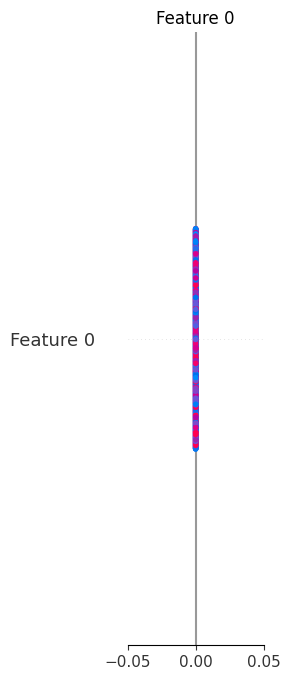

In [48]:
shap.summary_plot(shap_combined, features=np.hstack([X_numeric, X_categorical]))


In [ ]:
shap.image_plot(shap_images, X_images)

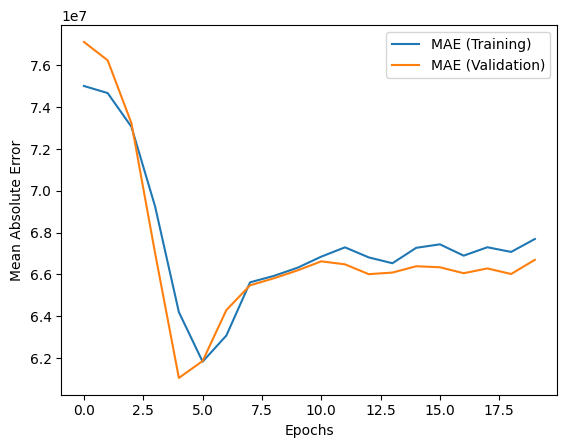

In [27]:
# Performans Analizi
plt.figure()
plt.plot(history.history['mae'], label='MAE (Training)')
plt.plot(history.history['val_mae'], label='MAE (Validation)')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()


In [ ]:
# Verilerin Kaydedilmesi
np.save('/mnt/data/X_images.npy', X_images)
np.save('/mnt/data/X_numeric.npy', X_numeric)
np.save('/mnt/data/X_categorical.npy', X_categorical)
np.save('/mnt/data/Y.npy', Y)

print("Ön işleme, modelleme ve analiz tamamlandı. Veriler kaydedildi.")